In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
from BiasedErasure.main_code.Simulator import *
from BiasedErasure.main_code.noise_channels import atom_array
from BiasedErasure.delayed_erasure_decoders.HeraldedCircuit_SWAP_LD import HeraldedCircuit_SWAP_LD


In [22]:
def simulate(noise_params={}, distance=5, printing=False, output_dir=''):
    cycles = 4
    decoder_basis = 'Z'
    num_rounds = 5
    gate_ordering = ['N', 'Z', 'Zr', 'Nr']
    Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis, 'bias_preserving_gates': 'False', 
        'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None', 'SSR': 'True', 'cycles': str(num_rounds - 1),
            'ordering': gate_ordering,
            'decoder': 'ML',
        'circuit_type': 'memory', 'Steane_type': 'regular', 'printing': str(printing), 'num_logicals': '1', 'loss_decoder': 'independent', 'obs_pos': 'd-1', 'n_r': '0'}
    bloch_point_params = {'erasure_ratio': '1', 'bias_ratio': '0.5'}
    
    print(noise_params)
    # Example data, change this:
    dx = distance
    dy = distance
    
    # simulator = Simulator(Meta_params=Meta_params, atom_array_sim=True, 
    #                             bloch_point_params=bloch_point_params, noise=atom_array , 
    #                             phys_err_vec=None, loss_detection_method=HeraldedCircuit_SWAP_LD, 
    #                             cycles = cycles, output_dir=output_dir, save_filename=None, save_data_during_sim=False)
    
    # meas, det = simulator.sampling_with_loss(num_losses=num_losses, num_shots_per_loss=num_shots_per_loss, dx=dx, dy=dy,
    #                                         noise_params=noise_params, sample_from_given_loss_pattern=sample_from_given_loss_pattern,
    #                                         loss_detection_events_all_shots=loss_detection_events_all_shots)

    meas_exp = np.load(f'{output_dir}/measurement_events_{decoder_basis}_2024_08_18.npy')
    num_of_shots = len(meas_exp)


    meas_sim, _, _ , LogicalCircuit= get_simulated_measurement_events(Meta_params, distance, distance, num_of_shots, noise_params)


    measurement_events_no_loss_exp = meas_exp.copy() 
    measurement_events_no_loss_exp[measurement_events_no_loss_exp == 2] = 0
    meas_exp_only01 = measurement_events_no_loss_exp.astype(np.bool_)
    detection_events_exp, observable_flip_exp = LogicalCircuit.compile_m2d_converter().convert(measurements=meas_exp_only01, separate_observables=True)
    observable_flip_exp = observable_flip_exp.reshape(-1)


    measurement_events_no_loss_sim = meas_sim.copy() 
    measurement_events_no_loss_sim[measurement_events_no_loss_sim == 2] = 0
    meas_sim_only01 = measurement_events_no_loss_sim.astype(np.bool_)
    detection_events_sim, observable_flips_sim = LogicalCircuit.compile_m2d_converter().convert(measurements=meas_sim_only01, separate_observables=True)
    observable_flips_sim = observable_flips_sim.reshape(-1)



    # meas, det = simulator.sampling_with_loss_old(num_shots_per_loss, dx, dy, None, noise_params=noise_params)
    return detection_events_sim, detection_events_exp

In [25]:
detector_order = np.array([
    *[0,1,3,5,8,10,13,15,18,20,22,23],
    *list(range(24)), *list(range(24)), *list(range(24)),
    *[0,1,3,5,8,10,13,15,18,20,22,23]
])
mapper = sum([list(np.argwhere(detector_order == detector_idx).flatten()) for detector_idx in range(24)], start=[])

def p_ij_matrix(detections: np.ndarray) -> np.ndarray:
    num_ancillas = 24
    num_time_steps = 4
    total_steps = num_ancillas * num_time_steps
    
    # Initialize the correlation matrix
    p_ij = np.zeros((total_steps, total_steps))

    # Precompute the means for all columns
    x_avg = np.mean(detections, axis=0)
    
    # Precompute the pairwise products
    # xixj_avg_matrix = np.dot(detections.T, detections) / detections.shape[0]
    xixj_avg_matrix = np.mean(np.einsum('ij,ik->ijk', detections, detections), axis=0)
    # Calculate the correlation matrix
    for idx_i in range(total_steps):
        for idx_j in range(idx_i + 1, total_steps):
            xi_avg = x_avg[idx_i]
            xj_avg = x_avg[idx_j]
            xixj_avg = xixj_avg_matrix[idx_i, idx_j]
            
            numerator = 4 * (xixj_avg - xi_avg * xj_avg)
            denominator = 1 - 2 * xi_avg - 2 * xj_avg + 4 * xixj_avg
            
            # Avoid dividing by zero or taking sqrt of a negative number
            if denominator > 0 and 1 - numerator / denominator >= 0:
                value = 0.5 - 0.5 * np.sqrt(1 - numerator / denominator)
                p_ij[idx_i, idx_j] = value
                p_ij[idx_j, idx_i] = value  # The matrix is symmetric

    return np.round(p_ij, 3)

def plot_pij(pij):
    ii, jj = np.meshgrid(mapper, mapper)
    num_detector_appearances = [len(np.argwhere(detector_order == detector_idx).flatten()) for detector_idx in range(24)]

    plt.figure(figsize=(20,20))
    plt.matshow(pij[ii,jj])
    positions = np.cumsum(num_detector_appearances)
    middle_position = list((np.ceil((positions + np.concatenate([[0], positions[:-1]]))/2)).astype(int))
    ticks = np.arange(96)
    labels = ['' if tick not in middle_position else f'D{middle_position.index(tick)}' for tick in ticks]
    plt.xticks(ticks, labels, rotation=90)
    plt.yticks(ticks, labels)
    for position in positions:
        plt.axhline(position-0.5, c='white', lw=1, alpha=0.3)
        plt.axvline(position-0.5, c='white', lw=1, alpha=0.3)
    # plt.savefig('./pij.pdf', bbox_inches='tight')

def plot_pij_side_by_side(pij_exp, pij_sim):
    # Calculate difference matrix
    pij_diff = pij_exp - pij_sim
    num_detector_appearances = [len(np.argwhere(detector_order == detector_idx).flatten()) for detector_idx in range(24)]
    ii, jj = np.meshgrid(mapper, mapper)
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    pij_matrices = [pij_exp[ii, jj], pij_sim[ii, jj], pij_diff[ii, jj]]
    titles = ['Experiment', 'Simulation', 'Difference']
    positions = np.cumsum(num_detector_appearances)
    middle_position = list((np.ceil((positions + np.concatenate([[0], positions[:-1]]))/2)).astype(int))
    ticks = np.arange(96)
    labels = ['' if tick not in middle_position else f'D{middle_position.index(tick)}' for tick in ticks]
    for i in range(3):
        ax = axes[i]
        cax = None
        if i<2:
            cax = ax.matshow(pij_matrices[i], vmin=pij_matrices[1].min(), vmax=pij_matrices[1].max())
        else:
            cax = ax.matshow(pij_matrices[i], vmin=-0.025, vmax=0.025)#, cmap='bwr')
            # cax = ax.matshow(pij_matrices[i], vmin=-0.025, vmax=0.025)#, cmap='bwr')
        # cax = ax.matshow(pij_matrices[i])
        ax.set_title(titles[i], pad=20)
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation=90)
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)
        for position in positions:
            ax.axhline(position-0.5, c='white', lw=1, alpha=0.3)
            ax.axvline(position-0.5, c='white', lw=1, alpha=0.3)
        fig.colorbar(cax, ax=ax)
    plt.show()

### plot P_ij for a specific error model:

In [24]:

noise_params = {'idle_loss_rate': 6.309193232062187e-08, 
                'idle_error_rate': np.array([9.02913693e-09, 3.18504909e-08, 1.16144569e-06]), 
                'entangling_zone_error_rate': np.array([1.04139008e-04, 1.35017074e-05, 1.90883958e-03]), 
                'entangling_gate_error_rate': [1.6800690749028758e-05, 0.0003593259863941469, 0.0006157368426828966, 1.6800690749028758e-05, 0, 0, 0, 0.0003593259863941469, 0, 0, 0, 0.0006157368426828966, 0, 0, 0.0012546625632592551], 
                'entangling_gate_loss_rate': 0.0016598578449429316, 'single_qubit_error_rate': np.array([4.44574963e-05, 1.20258220e-04, 7.48173488e-05]), 
                'reset_error_rate': 0.00033737913782721634, 'measurement_error_rate': 0.0014989883109622702, 'reset_loss_rate': 0.0031064464259778365, 
                'measurement_loss_rate': 0.009257094234993605, 'ancilla_idle_loss_rate': 1.7308745478966232e-07, 
                'ancilla_idle_error_rate': np.array([3.89737366e-08, 2.20486666e-08, 2.35800336e-06]),
                'ancilla_reset_error_rate': 0.05699373711411181, 'ancilla_measurement_error_rate': 0.009401322473053326, 
                'ancilla_reset_loss_rate': 0.0009450105000758211, 'ancilla_measurement_loss_rate': 0.0013587219962043042,
                'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 
                'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}

output_dir = '/Users/gefenbaranes/Lukin SiV Dropbox/Gefen Baranes/local_Repetitive_QEC'



det_sim, det_exp = simulate(noise_params=noise_params, output_dir=output_dir)


{'idle_loss_rate': 6.309193232062187e-08, 'idle_error_rate': array([9.02913693e-09, 3.18504909e-08, 1.16144569e-06]), 'entangling_zone_error_rate': array([1.04139008e-04, 1.35017074e-05, 1.90883958e-03]), 'entangling_gate_error_rate': [1.6800690749028758e-05, 0.0003593259863941469, 0.0006157368426828966, 1.6800690749028758e-05, 0, 0, 0, 0.0003593259863941469, 0, 0, 0, 0.0006157368426828966, 0, 0, 0.0012546625632592551], 'entangling_gate_loss_rate': 0.0016598578449429316, 'single_qubit_error_rate': array([4.44574963e-05, 1.20258220e-04, 7.48173488e-05]), 'reset_error_rate': 0.00033737913782721634, 'measurement_error_rate': 0.0014989883109622702, 'reset_loss_rate': 0.0031064464259778365, 'measurement_loss_rate': 0.009257094234993605, 'ancilla_idle_loss_rate': 1.7308745478966232e-07, 'ancilla_idle_error_rate': array([3.89737366e-08, 2.20486666e-08, 2.35800336e-06]), 'ancilla_reset_error_rate': 0.05699373711411181, 'ancilla_measurement_error_rate': 0.009401322473053326, 'ancilla_reset_loss

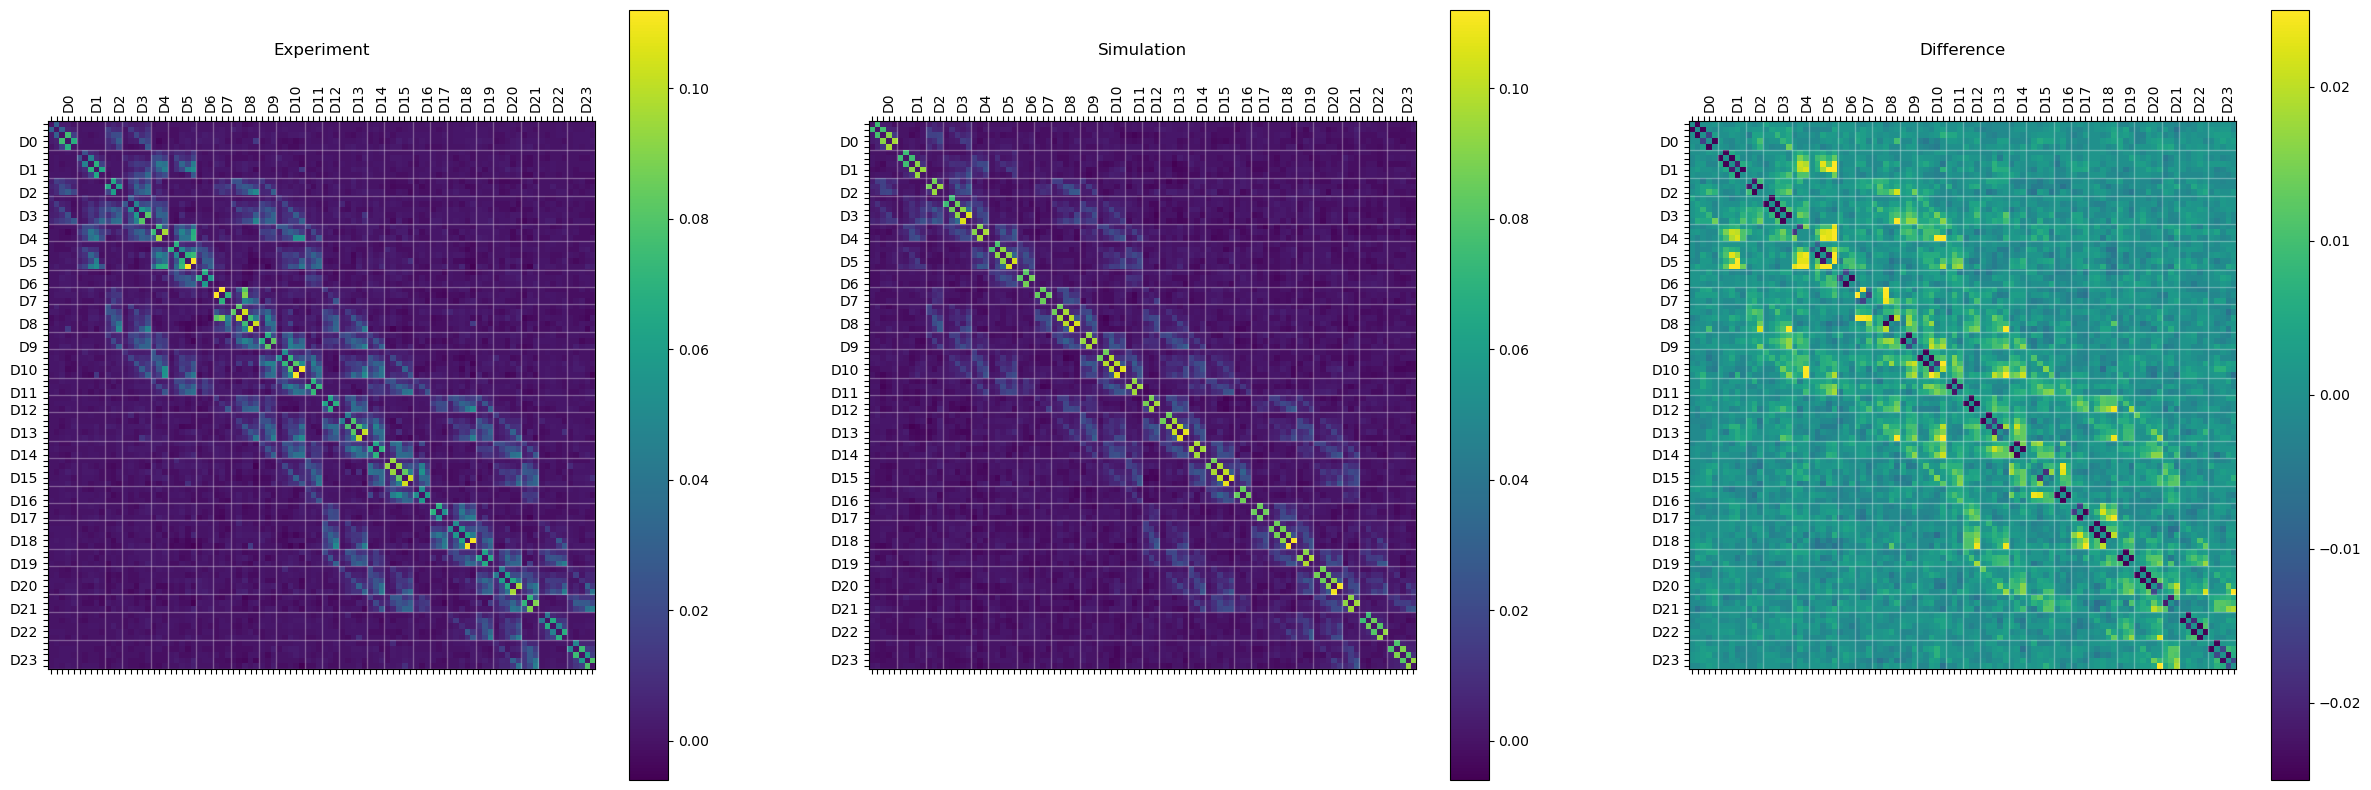

In [28]:
sim_cov = p_ij_matrix(det_sim)
exp_cov = p_ij_matrix(det_exp)

plot_pij_side_by_side(exp_cov, sim_cov)



### Get Pij for some error configuration:

  0%|          | 0/28 [00:00<?, ?it/s]

{'idle_loss_rate': 6e-07, 'idle_error_rate': array([0., 0., 0.]), 'entangling_zone_error_rate': array([0., 0., 0.]), 'entangling_gate_error_rate': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'entangling_gate_loss_rate': 0.0, 'single_qubit_error_rate': array([0., 0., 0.]), 'reset_error_rate': 0.0, 'measurement_error_rate': 0.0}
entangling Pauli error rate = None, entangling loss rate = None
Using orderings: ['N', 'Z', 'Zr', 'Nr']
{'idle_loss_rate': 0.0, 'idle_error_rate': array([1.6e-06, 0.0e+00, 0.0e+00]), 'entangling_zone_error_rate': array([0., 0., 0.]), 'entangling_gate_error_rate': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'entangling_gate_loss_rate': 0.0, 'single_qubit_error_rate': array([0., 0., 0.]), 'reset_error_rate': 0.0, 'measurement_error_rate': 0.0}
entangling Pauli error rate = None, entangling loss rate = None
Using orderings: ['N', 'Z', 'Zr', 'Nr']
{'idle_loss_rate': 0.0, 'idle_error_rate': array([0.0e+00, 1.6e-06, 0.0

KeyboardInterrupt: 

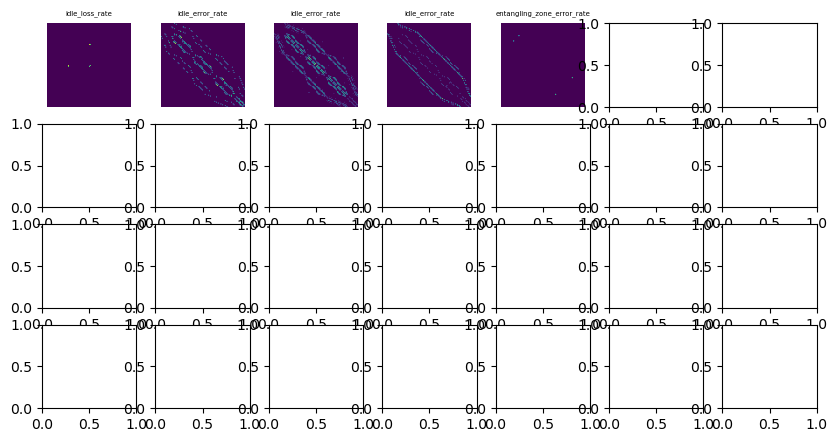

In [29]:
from tqdm.auto import *
maximums = np.array([
        3e-6, *[8e-6]*3, *[0.05/4]*3, *[0.05/4]*15, 0.05/4, *[1e-3]*3, 0.03, 0.04 
    ])
to_dict = lambda noise_params: dict(
        idle_loss_rate=noise_params[0],
        idle_error_rate=noise_params[1:4],
        entangling_zone_error_rate=noise_params[4:7],
        entangling_gate_error_rate=noise_params[7:22],
        entangling_gate_loss_rate=noise_params[22],
        single_qubit_error_rate=noise_params[23:26],
        reset_error_rate=noise_params[26],
        measurement_error_rate=noise_params[27]
    )
keys = ['idle_loss_rate', *['idle_error_rate']*3, *['entangling_zone_error_rate']*3, 
        *['entangling_gate_error_rate']*15, 'entangling_gate_loss_rate', *['single_qubit_error_rate']*3,
        'reset_error_rate', 'measurement_error_rate'
        ]
distance = 5
fig, axes = plt.subplots(4,7,figsize=(10,5))
axes = axes.flatten()
for i in trange(28):
    x = np.zeros(28)
    x[i] = maximums[i]/5
    meas, det = simulate(noise_params=to_dict(x), num_losses=1, num_shots_per_loss=10000, distance = distance, printing=False)
    cov_ = p_ij_matrix(det.numpy(), d=distance).flatten()
    cov_ /= np.linalg.norm(cov_)
    tmp = int(np.sqrt(len(cov_)))
    axes[i].imshow(cov_.reshape((tmp,tmp)))
    axes[i].axis('off')
    axes[i].set_title(f'{keys[i]}', fontsize=5)

fig.tight_layout()

### Plotting Pij for a specific known loss configuration:

In [35]:
%load_ext autoreload
%autoreload 2


from tqdm.auto import *
maximums = np.array([
        3e-6, *[8e-6]*3, *[0.05/4]*3, *[0.05/4]*15, 0.05/4, *[1e-3]*3, 0.03, 0.04 
    ])
to_dict = lambda noise_params: dict(
        idle_loss_rate=noise_params[0],
        idle_error_rate=noise_params[1:4],
        entangling_zone_error_rate=noise_params[4:7],
        entangling_gate_error_rate=noise_params[7:22],
        entangling_gate_loss_rate=noise_params[22],
        single_qubit_error_rate=noise_params[23:26],
        reset_error_rate=noise_params[26],
        measurement_error_rate=noise_params[27]
    )
keys = ['idle_loss_rate', *['idle_error_rate']*3, *['entangling_zone_error_rate']*3, 
        *['entangling_gate_error_rate']*15, 'entangling_gate_loss_rate', *['single_qubit_error_rate']*3,
        'reset_error_rate', 'measurement_error_rate'
        ]
fig  = plt.figure()
d = 5
distance = d
decoder_basis = 'Z'
num_rounds = 5


data_source = 't'


if data_source == 'e':
    # import from the experiment:
    output_dir = "/Users/gefenbaranes/Lukin SiV Dropbox/Gefen Baranes/RepetitiveQEC/Analysis/Data/July2024_repetitiveQEC_preprocessing/d%i/r%i/%s/final_data"%(distance,num_rounds - 1,decoder_basis)
    det_exp = np.load(f"{output_dir}/experimental_detection_events{decoder_basis}.npy")
    print(det_exp.shape)
    cov = p_ij_matrix(det_exp)
    cov /= np.linalg.norm(cov)
    
# theory:
if data_source == 't':
    independent_error_sources = [22]
    loss_detection_events_all_shots = np.load("loss_detection_events_all_shots.npy")
    
    for i in independent_error_sources:
        print(f"results for only channel i = {i}")
        x = np.zeros(28)
        x[i] = maximums[i]
        # x = maximums / 5
        
        meas, det = simulate(noise_params=to_dict(x), num_losses=100, num_shots_per_loss=1000, distance = d, printing=True, sample_from_given_loss_pattern=False, loss_detection_events_all_shots=loss_detection_events_all_shots)
        print(det.numpy().shape)
        detection_events = det_exp if data_source == 'e' else det
        cov = p_ij_matrix(detection_events.numpy(), d)
        cov /= np.linalg.norm(cov)

    # print(f"Now lets take all error sources together")
    # x[independent_error_sources] = maximums[independent_error_sources]/5
    # meas, det = simulate(noise_params=to_dict(x), num_losses=1, num_shots_per_loss=10000, distance = d, printing=True, sample_from_given_loss_pattern=True, loss_detection_events_all_shots=loss_detection_events_all_shots)
    # print(det.numpy().shape)
    # detection_events = det_exp if data_source == 'e' else det
    # cov = p_ij_matrix(detection_events.numpy(), d)
    # cov /= np.linalg.norm(cov)
    
    

ii, jj = np.meshgrid(mapper, mapper)
num_detector_appearances = [len(np.argwhere(detector_order == detector_idx).flatten()) for detector_idx in range(24)]

plt.figure(figsize=(20,20))
plt.matshow(cov[ii,jj])
positions = np.cumsum(num_detector_appearances)
middle_position = list((np.ceil((positions + np.concatenate([[0], positions[:-1]]))/2)).astype(int))
ticks = np.arange(96)
labels = ['' if tick not in middle_position else f'D{middle_position.index(tick)}' for tick in ticks]
plt.xticks(ticks, labels, rotation=90)
plt.yticks(ticks, labels)
plt.colorbar()
for position in positions:
    plt.axhline(position-0.5, c='white', lw=1, alpha=0.3)
    plt.axvline(position-0.5, c='white', lw=1, alpha=0.3)
plt.savefig('./cov.pdf', bbox_inches='tight')



fig.tight_layout()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
results for only channel i = 22
{'idle_loss_rate': 0.0, 'idle_error_rate': array([0., 0., 0.]), 'entangling_zone_error_rate': array([0., 0., 0.]), 'entangling_gate_error_rate': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'entangling_gate_loss_rate': 0.0125, 'single_qubit_error_rate': array([0., 0., 0.]), 'reset_error_rate': 0.0, 'measurement_error_rate': 0.0}
entangling Pauli error rate = None, entangling loss rate = None
Using orderings: ['N', 'Z', 'Zr', 'Nr']
Starting QEC Round 0
Starting QEC Round 1
Starting QEC Round 2
Starting QEC Round 3
Using None method for 4 cycles and dx = 5, dy = 5, self.qubit_lifecycles_and_losses = {0: [[0, 0, None], [1, 1, None], [2, 2, None], [3, 3, None]], 1: [[0, 0, None], [1, 1, None], [2, 2, None], [3, 3, None]], 7: [[0, 0, None], [1, 1, None], [2, 2, None], [3, 3, None]], 8: [[0, 0, None], [1, 1, None], [2, 2, None], [3, 3, None]], 9: [[0

ValueError: operands could not be broadcast together with shapes (100,) () (100,121) 

<Figure size 640x480 with 0 Axes>

## Checking if Pij are additive --> Comparing independent error channel or a linear combination:

results for only channel i = 1
{'idle_loss_rate': 0.0, 'idle_error_rate': array([1.6e-06, 0.0e+00, 0.0e+00]), 'entangling_zone_error_rate': array([0., 0., 0.]), 'entangling_gate_error_rate': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'entangling_gate_loss_rate': 0.0, 'single_qubit_error_rate': array([0., 0., 0.]), 'reset_error_rate': 0.0, 'measurement_error_rate': 0.0}
entangling Pauli error rate = None, entangling loss rate = None
Using orderings: ['N', 'Z', 'Zr', 'Nr']
0.0
0.0
/loss_circuits/CBQC__Rotated_Surface__memory__1log__Z__0__atom_array__0__LD_freq_100__SSR_1__LD_method_None__ordering_N_Z_Zr_Nr/dx_5__dy_5__c_4
Starting QEC Round 0
Starting QEC Round 1
Starting QEC Round 2
Starting QEC Round 3
Using None method for 4 cycles and dx = 5, dy = 5, self.qubit_lifecycles_and_losses = {0: [[0, 0, None], [1, 1, None], [2, 2, None], [3, 3, None]], 1: [[0, 0, None], [1, 1, None], [2, 2, None], [3, 3, None]], 7: [[0, 0, None], [1, 1, None], [2, 2, None], [3, 3, 

<Figure size 640x480 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

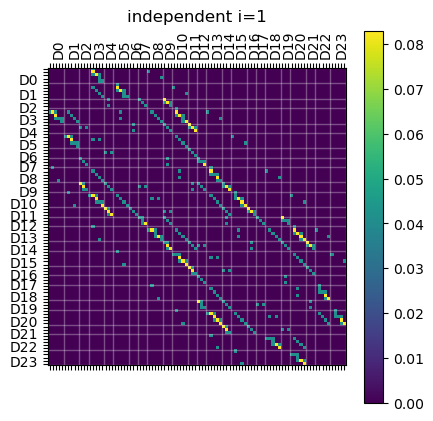

<Figure size 2000x2000 with 0 Axes>

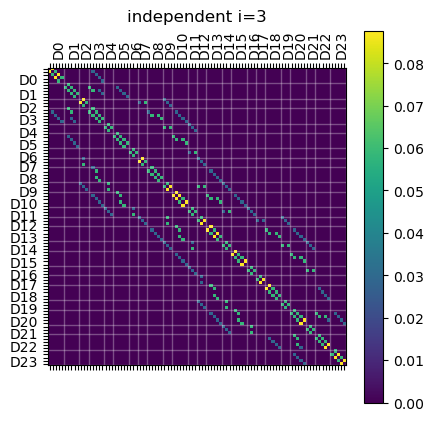

<Figure size 2000x2000 with 0 Axes>

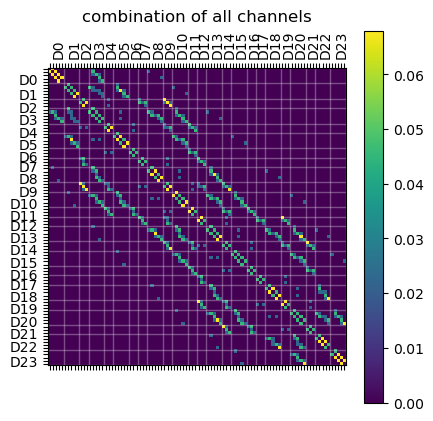

In [26]:
from tqdm.auto import *
maximums = np.array([
        3e-6, *[8e-6]*3, *[0.05/4]*3, *[0.05/4]*15, 0.05/4, *[1e-3]*3, 0.03, 0.04 
    ])
to_dict = lambda noise_params: dict(
        idle_loss_rate=noise_params[0],
        idle_error_rate=noise_params[1:4],
        entangling_zone_error_rate=noise_params[4:7],
        entangling_gate_error_rate=noise_params[7:22],
        entangling_gate_loss_rate=noise_params[22],
        single_qubit_error_rate=noise_params[23:26],
        reset_error_rate=noise_params[26],
        measurement_error_rate=noise_params[27]
    )
keys = ['idle_loss_rate', *['idle_error_rate']*3, *['entangling_zone_error_rate']*3, 
        *['entangling_gate_error_rate']*15, 'entangling_gate_loss_rate', *['single_qubit_error_rate']*3,
        'reset_error_rate', 'measurement_error_rate'
        ]
fig  = plt.figure()
d = 5
distance = d
decoder_basis = 'Z'
num_rounds = 5



def plot_pij(cov, title):
    ii, jj = np.meshgrid(mapper, mapper)
    num_detector_appearances = [len(np.argwhere(detector_order == detector_idx).flatten()) for detector_idx in range(24)]

    plt.figure(figsize=(20,20))
    plt.matshow(cov[ii,jj])
    positions = np.cumsum(num_detector_appearances)
    middle_position = list((np.ceil((positions + np.concatenate([[0], positions[:-1]]))/2)).astype(int))
    ticks = np.arange(96)
    labels = ['' if tick not in middle_position else f'D{middle_position.index(tick)}' for tick in ticks]
    plt.xticks(ticks, labels, rotation=90)
    plt.yticks(ticks, labels)
    plt.title(title)
    plt.colorbar()
    for position in positions:
        plt.axhline(position-0.5, c='white', lw=1, alpha=0.3)
        plt.axvline(position-0.5, c='white', lw=1, alpha=0.3)
    # plt.savefig('./cov.pdf', bbox_inches='tight')
    fig.tight_layout()

data_source = 't'


if data_source == 'e':
    # import from the experiment:
    output_dir = "/Users/gefenbaranes/Lukin SiV Dropbox/Gefen Baranes/RepetitiveQEC/Analysis/Data/July2024_repetitiveQEC_preprocessing/d%i/r%i/%s/final_data"%(distance,num_rounds - 1,decoder_basis)
    det_exp = np.load(f"{output_dir}/experimental_detection_events{decoder_basis}.npy")
    print(det_exp.shape)
    cov = p_ij_matrix(det_exp)
    cov /= np.linalg.norm(cov)
    plot_pij(cov,"experimental data")
    
# theory:
if data_source == 't':
    independent_error_sources = [1,3]
    covs = {}
    loss_detection_events_all_shots = np.load("loss_detection_events_all_shots.npy")
    num_shots_per_loss = 100000
    for i in independent_error_sources:
        print(f"results for only channel i = {i}")
        x = np.zeros(28)
        x[i] = maximums[i]/5
        # x = maximums / 5
        
        meas, det = simulate(noise_params=to_dict(x), num_losses=1, num_shots_per_loss=num_shots_per_loss, distance = d, printing=True, sample_from_given_loss_pattern=True, loss_detection_events_all_shots=loss_detection_events_all_shots)
        print(det.numpy().shape)
        detection_events = det_exp if data_source == 'e' else det
        cov = p_ij_matrix(detection_events.numpy(), d)
        cov /= np.linalg.norm(cov)
        title = f"independent i={i}"
        plot_pij(cov, title)
        covs[str(i)] = cov

    print(f"Now lets take all error sources together")
    x = np.zeros(28)
    x[independent_error_sources] = maximums[independent_error_sources]/5
    print(x)
    meas, det = simulate(noise_params=to_dict(x), num_losses=1, num_shots_per_loss=num_shots_per_loss, distance = d, printing=True, sample_from_given_loss_pattern=True, loss_detection_events_all_shots=loss_detection_events_all_shots)
    print(det.numpy().shape)
    detection_events = det_exp if data_source == 'e' else det
    cov = p_ij_matrix(detection_events.numpy(), d)
    cov /= np.linalg.norm(cov)
    title = "combination of all channels"
    covs['all'] = cov
    plot_pij(cov,title)




<Figure size 2000x2000 with 0 Axes>

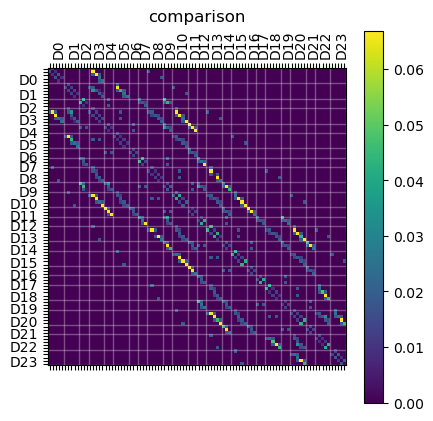

In [32]:
covs_sum_independent = covs['1'] + covs['3']
covs_all = covs['all']

plot_pij(abs(covs_all - covs_sum_independent),"comparison")
